In [1]:
# fmt: off
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "12_generation/12e_image_captioning.ipynb"
_nb_title = "Image Captions"
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))
# fmt: on

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Image+Captions&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F12_generation%2F12e_image_captioning.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/12_generation/12e_image_captioning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/12_generation/12e_image_captioning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/12_generation/12e_image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# 画像のキャプショニング
このノートブックでは、画像のキャプションを生成するためにMLモデルをトレーニングする方法を示します。<br>
データセットには、オブジェクト検出、セグメンテーション、およびキャプションを含む大規模なCOCOデータセットを利用します。

## 環境設定

**このノートブックは、GPUでの実行を前提としています。**

Vertex AI WorkbenchやColabでGPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.8.4
Found GPU at: /device:GPU:0


2023-04-15 22:55:34.441745: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 22:55:36.765011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 22:55:36.795770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 22:55:36.797515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## インストールとパラメータの設定

In [3]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

print(tf.version.VERSION)

2.8.4


In [4]:
# Change these to control the accuracy/speed
VOCAB_SIZE = 20000  # use fewer words to speed up convergence
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128

# InceptionResNetV2 takes (299, 299, 3) image as inputs
# and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

2023-04-15 22:55:38.805988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 22:55:38.808092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 22:55:38.809796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 22:55:38.811850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 22:55:38.813641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

## データセットを読み取って可視化する  

TensorFlowデータセット機能を使用して、[COCOキャプション](https://www.tensorflow.org/datasets/catalog/coco_captions)データセットを読み取ります。  
このバージョンには、COCO 2014の画像、バウンディングボックス、ラベル、キャプションが含まれており、[Deep Visual-Semantic Alignments for Generating Image Descriptions](https://arxiv.org/abs/1412.2306)によって定義されたサブセットに分割されています。

**注**：このデータセットは大きすぎて、一時的な場所に保存できません。そのため、本書のGCSバケットにデータを格納しています。<br>
米国外のノートブックからアクセスすると、速度が遅くなり、またGoogle Cloud上のノートブックの場合ネットワーク料金の対象となります。

In [5]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000


def get_image_label(example):
    caption = example["captions"]["text"][0]  # only the first caption per image
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "caption": caption}


trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

trainds = trainds.map(
    get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

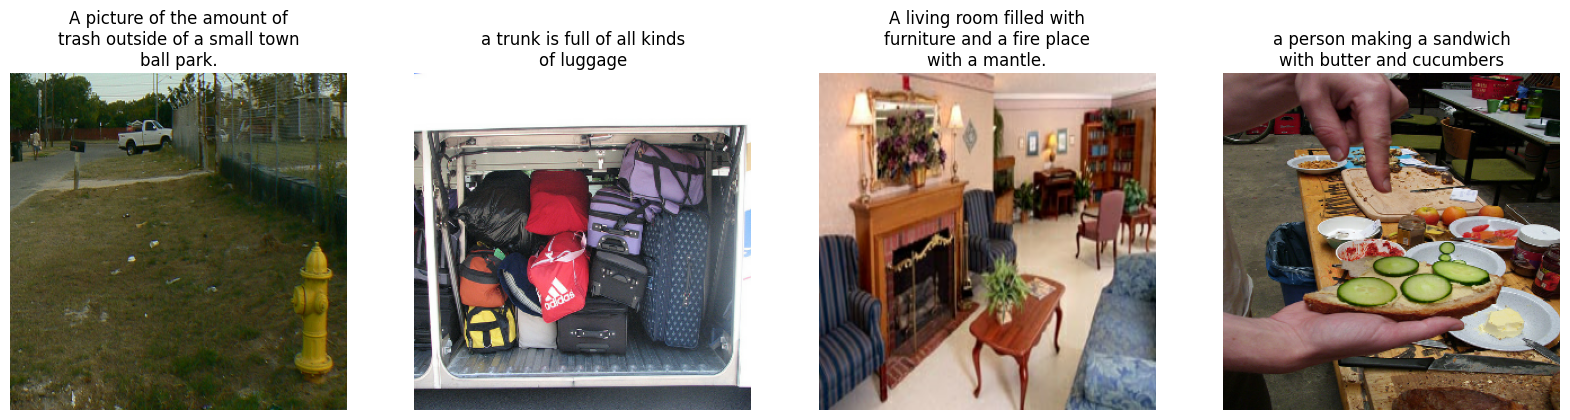

In [6]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

## キャプションの前処理

各キャプションに開始トークンと終了トークンを追加します。<br>

In [7]:
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start>")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join(
        [start, data["caption"], end], separator=" "
    )
    return data


trainds = trainds.map(add_start_end_token)

次に、`TextVectorization`を使用してテキストの前処理を行います。

`TextVectorization`を利用することで、キャプションを小文字にしたり、句読点などを削除したり、指定した長さにパディングしたりといった一般的な前処理を行うことができます。<br>
また、`VOCAB_SIZE`で設定された数だけの頻繁な単語だけを保存し、その他は未知語(`[UNK]`)として扱います。

`.adapt()`で全データセットに対して適用し、インデックスを作成します。この処理には5分ほどの時間がかかります。

In [8]:
MAX_CAPTION_LEN = 64


# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))

作成したtokenizerを試してみましょう。

In [9]:
tokenizer(["<start> This is a sentence <end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  3, 165,  11,   2,   1,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [10]:
sample_captions = []
for d in trainds.take(5):
    sample_captions.append(d["caption"].numpy())

In [11]:
sample_captions

[b'<start> A lone building that is next to a fire hydrant. <end>',
 b'<start> Several zebras standing in the dirt near rocks. <end>',
 b'<start> a man in a blue track suit leading a cow <end>',
 b'<start> Girls playing Frisbee in a green park with other people standing and sitting on the other side. <end>',
 b'<start> A glowing traditional clock outside of a building. <end>']

In [12]:
print(tokenizer(sample_captions))

tf.Tensor(
[[   3    2  743   71   28   11   16   13    2  140  173    4    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3  125  239   15    8    7  196   46  502    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    2   12    8    2   58  306  281  892    2  255    4    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

ここで、単語とインデックスを入れ替えるためのルックアッテーブルを作成しておきましょう。

In [13]:
# Lookup table: Word -> Index
word_to_index = tf.keras.layers.StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = tf.keras.layers.StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

## tf.dataパイプライン
学習用のtf.dataパイプラインを作成します。

ここで、ラベルも作成していることに注目してください。キャプションに対して次の単語を予測するラベルとなるので、単語一つ分シフトしてラベルを作成しますします。<br>
キャプションが `"<start> I love cats <end>"`であれば、ラベルは `"I love cats <end> <padding>"`となります。
モデルは、`<start>`の入力から`I`を、`I`の入力から`love`を予測するように学習を行います。

最終的に、この関数は特徴量とラベルのタプルを返しますが、さらに特徴量は`(画像テンソル, キャプション)`のタプルとなっています。

In [14]:
BATCH_SIZE = 32


def create_ds_fn(data):
    img_tensor = data["image_tensor"]
    caption = tokenizer(data["caption"])

    target = tf.roll(caption, -1, 0)
    zeros = tf.zeros([1], dtype=tf.int64)
    target = tf.concat((target[:-1], zeros), axis=-1)
    return (img_tensor, caption), target


batched_ds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

データの形態を確認してみましょう。

In [15]:
for (img, caption), label in batched_ds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])

Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[   3    2  151   61    6    2 2456 2460    7  406   13    2   42  653
    4    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
tf.Tensor(
[   2  151   61    6    2 2456 2460    7  406   13    2   42  653    4
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3   2 170  45 140 121 136  99 267   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  

## キャプショニングモデルを作成する  

モデルは画像エンコーダーと、それに続くキャプションデコーダーで構成されています。  
キャプションデコーダーには、アテンションメカニズムが組み込まれており、デコーダーから入力画像の各部分に注目します。

### 画像エンコーダ
画像エンコーダは、CNNのバックボーンを使用して埋め込みを作成し、デコーダでアテンション層へ入力するために、2Dに変換しておきます。

In [16]:
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)

In [17]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 reshape (Reshape)           (None, 64, 1536)          0         
                                                                 
 dense (Dense)               (None, 64, 512)           786944    
                                                                 
Total params: 55,123,680
Trainable params: 786,944
Non-trainable params: 54,336,736
_________________________________________________________________


## キャプションデコーダ
キャプションを生成するデコーダでは、アテンション層を利用して、キャプションから画像へと注意を向けます。

また、ここではGRUも使用していますが、スキップ接続やLayerNormalization層など、Transformerブロックに近い構造を導入してモデルをアップデートしてみましょう。

In [18]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_atention = Attention()
context_vector = decoder_atention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

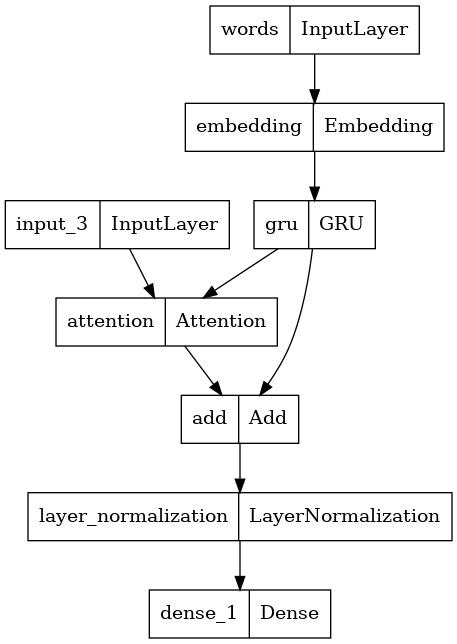

In [19]:
decoder = tf.keras.Model(
    inputs=[word_input, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)

In [20]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words (InputLayer)             [(None, 64)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 64, 512)      10240000    ['words[0][0]']                  
                                                                                                  
 gru (GRU)                      [(None, 64, 512),    1575936     ['embedding[1][0]']              
                                 (None, 512)]                                                     
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 512)]    0           []                         

### モデル全体の作成

In [21]:
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)

## 損失関数
損失関数には予測単語についてのクロスエントロピーを用います。

しかし、パディングされた箇所(`0`)は除く必要がありますので注意して下さい。

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)

In [23]:
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

## 学習グループ  
`model.fit`を呼び出し、モデルの学習を行います。

学習には、NVIDIA T4 GPUを利用した場合で、およそ15-20分ほどかかります。

In [24]:
%%time
history = image_caption_train_model.fit(batched_ds, epochs=1)

2023-04-15 23:01:03.046825: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14258995200 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-04-15 23:01:08.984642: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


2586/2586 [==============================] - 975s 370ms/step - loss: 0.5642
CPU times: user 14min 32s, sys: 1min 56s, total: 16min 29s
Wall time: 16min 15s


## キャプション生成  

学習が終わったので、推論用のモデルを作成します。

推論時には、Teacher-Forcingは適用しませんので、カスタムの予測ループを作成する必要があります。<br>
学習時にはKerasが自動的にGRUのステートを文章毎に保持して利用していましたが、カスタムループでは明示的にステートの初期化や保持を制御する必要があります。

それを行うために、学習した層を利用しながら、GRUのステートを渡すことのできるように少しだけモデルのI/Oに変更を加えます。<br>
（上で定義されたデコーダの定義と比べてみると違いが分かりやすくなります）


In [25]:
gru_state_input = Input(shape=(ATTENTION_DIM), name="gru_state_input")

# Reuse trained GRU, but update it so that it can receive states.
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_atention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state],
)

では、実際にキャプション生成を行ってみましょう。

推論ループは以下のステップを踏みます。
1. GRUのステートを初期化する
2. エンコーダを使用して画像の埋め込みを作成する
3. 最初の単語として`<start>`トークンを用意する
4. `for` ループの中で、デコーダを使って次々に単語を予測する。その際、GRUのステートを更新したり、予測にランダムな要素を導入していたり、予測した単語を次のステップの入力としているなどの点に注目してください。

In [26]:
MINIMUM_SENTENCE_LENGTH = 5


## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word_to_index("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

a baseball player holding a ball while standing in a field.
a baseball player holding bat while standing on a field.
a baseball player in a uniform while holding a baseball bat.
a baseball player is hitting the ball on a field.
baseball player standing on a baseball field holding bat.


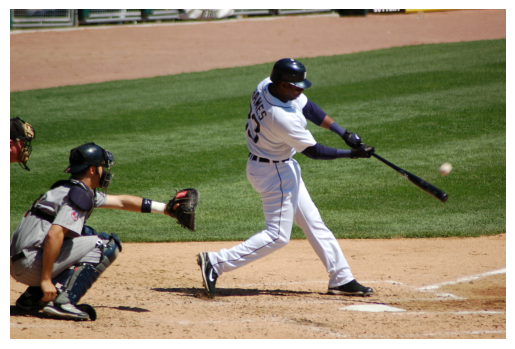

In [30]:
filename="./sample_images/baseball.jpeg" # ./sample_images/surf.jpeg

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

文法的に正確ではありませんが、モデルは画像の重要な特徴(人、フィールド、野球)をキャプチャすることができているようです。

ぜひ、手元の他の画像に入れ替えて、キャプション生成を試してみてください。

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.